In [1]:
from datasets import load_dataset, load_metric, Audio, Dataset
from tqdm.auto import tqdm

import os
import numpy as np
import pandas as pd
import torchaudio

os.environ["WANDB_DISABLED"] = "true"

In [2]:
timit_path = '/Users/daiyi/Downloads/timit/'
data_path = '/Users/daiyi/Downloads/timit/data'


In [3]:
df_train = pd.read_csv(os.path.join(timit_path, 'train_data.csv'))
df_test = pd.read_csv(os.path.join(timit_path, 'test_data.csv'))
df = pd.concat([df_train, df_test])
df = df[df['is_converted_audio'] == False]

In [4]:
df

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
1,2.0,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,3.0,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,4.0,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,5.0,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False
5,6.0,TRAIN,DR4,MMDM0,SI681.TXT,TRAIN/DR4/MMDM0/SI681.TXT,TRAIN\\DR4\\MMDM0\\SI681.TXT,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8394,8395.0,TEST,DR8,MPAM0,SX19.WAV,TEST/DR8/MPAM0/SX19.WAV,TEST\\DR8\\MPAM0\\SX19.WAV,False,True,False,False,False
8395,8396.0,TEST,DR8,MPAM0,SX109.TXT,TEST/DR8/MPAM0/SX109.TXT,TEST\\DR8\\MPAM0\\SX109.TXT,False,False,False,False,True
8397,8398.0,TEST,DR8,MPAM0,SX289.WRD,TEST/DR8/MPAM0/SX289.WRD,TEST\\DR8\\MPAM0\\SX289.WRD,False,False,True,False,False
8398,8399.0,TEST,DR8,MPAM0,SX109.WAV,TEST/DR8/MPAM0/SX109.WAV,TEST\\DR8\\MPAM0\\SX109.WAV,False,True,False,False,False


In [5]:
data = {}

for idx, row in tqdm(df.iterrows()):
    path = row['path_from_data_dir']
    entry_id = path.split('.')[0]

    if entry_id not in data:
        data[entry_id] = {}

    if row['is_audio'] is True:
        data[entry_id]['audio_file'] = os.path.join(data_path, path)
    elif row['is_word_file'] is True:
        data[entry_id]['word_file'] = os.path.join(data_path, path)
    elif row['is_phonetic_file'] is True:
        data[entry_id]['phonetic_file'] = os.path.join(data_path, path)

0it [00:00, ?it/s]

In [6]:
import random

keys = [key for key in data.keys() if len(data[key]) == 3]
random.Random(101).shuffle(keys)

num_train = int(len(keys) * 0.8)
num_valid = int(len(keys) * 0.1)
num_test = len(keys) - num_train - num_valid

train_keys = keys[:num_train]
valid_keys = keys[num_train:num_train + num_valid]
test_keys = keys[-num_test:]

In [7]:
train = { key:data[key] for key in train_keys }
valid = { key:data[key] for key in valid_keys }
test  = { key:data[key] for key in test_keys }

In [8]:
import librosa

def get_durations(dict_data):
    total_durations = 0

    for entry in dict_data.values():
        audio_data, _ = librosa.load(entry['audio_file'], sr=16_000)
        duration = len(audio_data) / 16_000
        total_durations += duration

    return int(total_durations)

In [9]:
print(f"Duration of Train: {get_durations(train) // 60} mns")
print(f"Duration of Valid: {get_durations(valid) // 60} mns")
print(f"Duration of Test : {get_durations(test) // 60} mns")

Duration of Train: 137 mns
Duration of Valid: 17 mns
Duration of Test : 17 mns


In [10]:
import json

with open("custom_train.json", "w") as f:
    json.dump(train, f)
with open("custom_valid.json", "w") as f:
    json.dump(valid, f)
with open("custom_test.json", "w") as f:
    json.dump(test, f)

In [11]:
def convert_to_feature_dict(data_dict):
    # convert each feature into an array instead
    audio_files = []
    word_files = []
    phonetic_files = []
    for key, value in data_dict.items():
        audio_files.append(value['audio_file'])
        word_files.append(value['word_file'])
        phonetic_files.append(value['phonetic_file'])
    
    return {
        'audio_file': audio_files,
        'word_file': word_files,
        'phonetic_file': phonetic_files
    }

In [12]:
train = convert_to_feature_dict(train)
valid = convert_to_feature_dict(valid)
test  = convert_to_feature_dict(test)
train_dataset = Dataset.from_dict(train)
valid_dataset = Dataset.from_dict(valid)
test_dataset = Dataset.from_dict(test)

In [13]:
print(train_dataset)

Dataset({
    features: ['audio_file', 'word_file', 'phonetic_file'],
    num_rows: 2688
})


In [14]:
def read_text_file(filepath):
    with open(filepath) as f:
        tokens = [line.split()[-1] for line in f]
        return " ".join(tokens)
    
def prepare_text_data(item):
    item['text'] = read_text_file(item['word_file'])
    item['phonetic'] = read_text_file(item['phonetic_file'])
    return item

In [15]:
train_dataset = (train_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))
valid_dataset = (valid_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))
test_dataset  = (test_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))

Map:   0%|          | 0/2688 [00:00<?, ? examples/s]

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

In [16]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
print("num of train phones:\t", len(set(train_phonetics)))

num of train phones:	 61


In [17]:
# TimitBet 61 phoneme mapping to 39 phonemes
# by Lee, K.-F., & Hon, H.-W. (1989). Speaker-independent phone recognition using hidden Markov models. IEEE Transactions on Acoustics, Speech, and Signal Processing, 37(11), 1641–1648. doi:10.1109/29.46546 
phon61_map39 = {
    'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',  'ax':'ah',   'ah':'ah',  'uw':'uw',
    'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',  'ay':'ay',   'oy':'oy',  'aw':'aw',
    'ow':'ow',  'l':'l',     'el':'l',  'r':'r',      'y':'y',    'w':'w',     'er':'er',  'axr':'er',
    'm':'m',    'em':'m',     'n':'n',    'nx':'n',     'en':'n',  'ng':'ng',   'eng':'ng', 'ch':'ch',
    'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',  'g':'g',     'p':'p',    't':'t',
    'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',    'th':'th',   's':'s',    'sh':'sh',
    'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 'qcl':'h#','bcl':'h#','dcl':'h#',
    'gcl':'h#','h#':'h#',  '#h':'h#',  'pau':'h#', 'epi': 'h#','nx':'n',   'ax-h':'ah','q':'h#' 
}

def convert_phon61_to_phon39(sentence):
    tokens = [phon61_map39[x] for x in sentence.split()]
    return " ".join(tokens)

def normalize_phones(item):
    item['phonetic'] = convert_phon61_to_phon39(item['phonetic'])
    return item

In [18]:
train_dataset = train_dataset.map(normalize_phones)
valid_dataset = valid_dataset.map(normalize_phones)
test_dataset = test_dataset.map(normalize_phones)

Map:   0%|          | 0/2688 [00:00<?, ? examples/s]

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

In [19]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
valid_phonetics = [phone for x in valid_dataset for phone in x['phonetic'].split()]
test_phonetics = [phone for x in test_dataset for phone in x['phonetic'].split()]

print("num of train phones:\t", len(set(train_phonetics)))
print("num of valid phones:\t", len(set(valid_phonetics)))
print("num of test phones:\t", len(set(test_phonetics)))

num of train phones:	 39
num of valid phones:	 39
num of test phones:	 39


In [20]:
phone_vocabs = set(train_phonetics)
phone_vocabs.remove('h#')
phone_vocabs = sorted(phone_vocabs)

def count_frequency(phonetics):
    phone_counts = {phone: 0 for phone in phone_vocabs}
    for phone in phonetics:
        if phone in phone_vocabs:
            phone_counts[phone] += 1
    # eliminate h# for visualization purposes
    return [phone_counts[phone] for phone in phone_vocabs] 

In [21]:
train_phone_counts = count_frequency(train_phonetics)
valid_phone_counts = count_frequency(valid_phonetics)
test_phone_counts  = count_frequency(test_phonetics)

train_phone_ratio = [count / sum(train_phone_counts) for count in train_phone_counts]
valid_phone_ratio = [count / sum(valid_phone_counts) for count in valid_phone_counts]
test_phone_ratio  = [count / sum(test_phone_counts) for count in test_phone_counts]

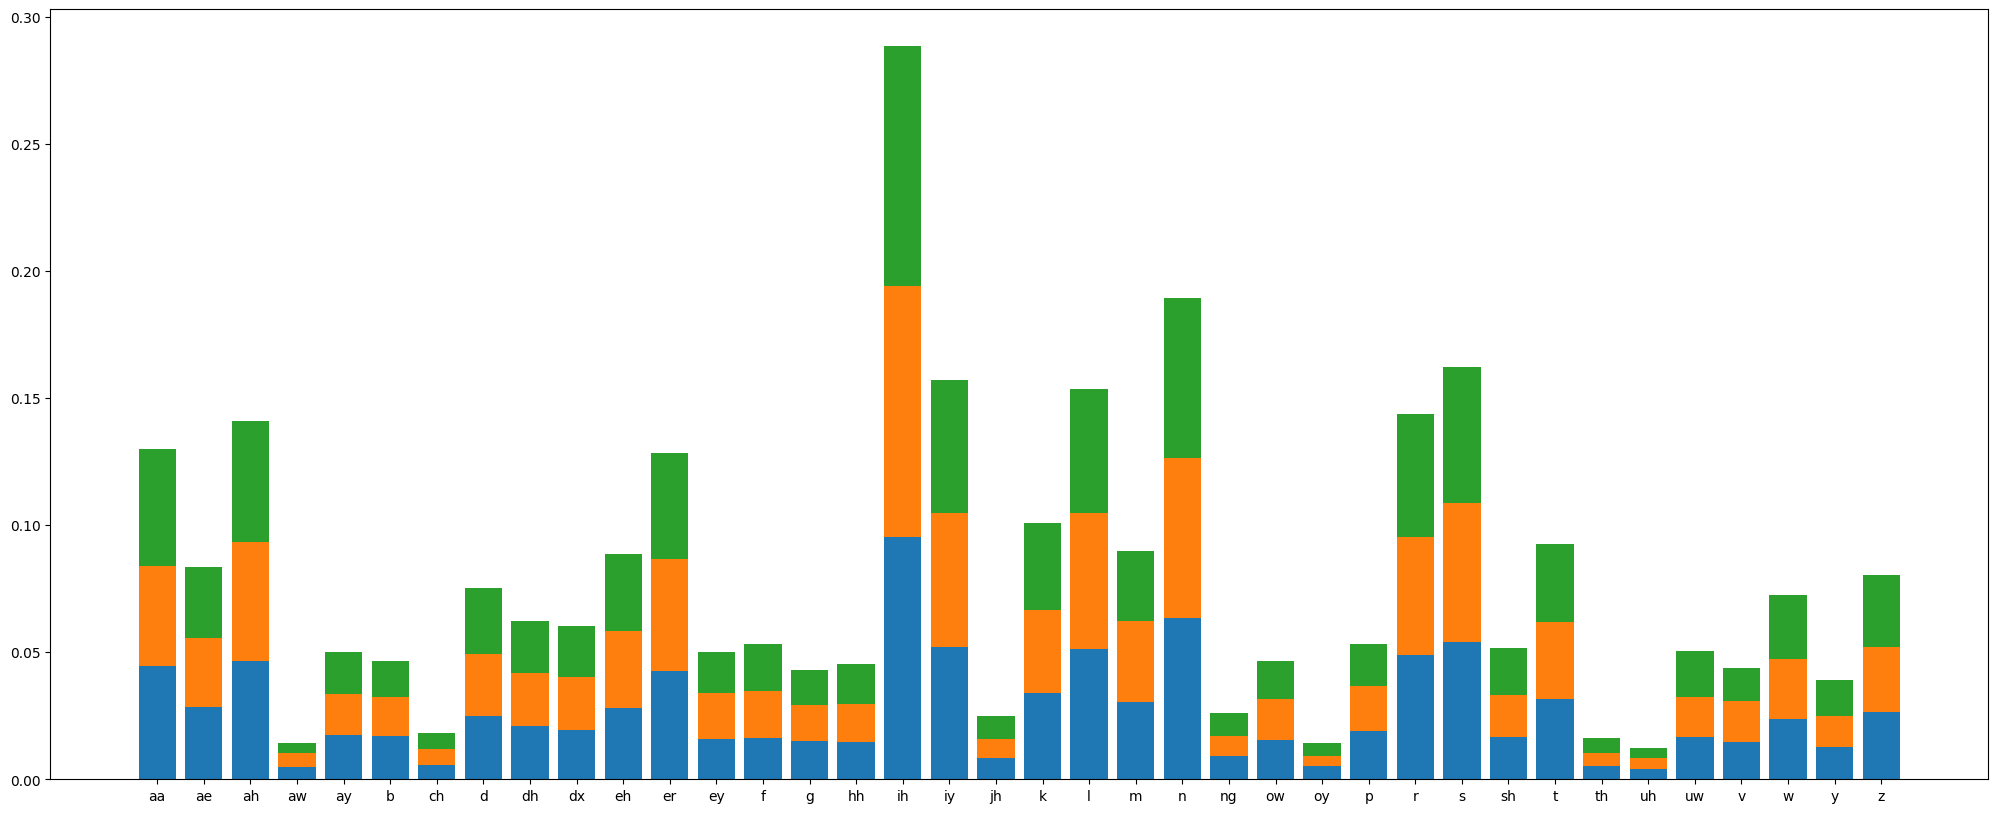

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))

plt.bar(phone_vocabs, train_phone_ratio)
plt.bar(phone_vocabs, valid_phone_ratio, bottom=train_phone_ratio)
plt.bar(phone_vocabs, test_phone_ratio, bottom=[(x+y) for x,y in zip(train_phone_ratio, valid_phone_ratio)])

plt.show()

In [23]:
train_dataset = (train_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
valid_dataset = (valid_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
test_dataset = (test_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))

In [24]:
train_dataset[0]

{'audio': {'path': '/Users/daiyi/Downloads/timit/data/TEST/DR7/FISB0/SA1.WAV',
  'array': array([-6.10351562e-05,  6.10351562e-05,  1.22070312e-04, ...,
          9.15527344e-05,  3.66210938e-04, -3.05175781e-04]),
  'sampling_rate': 16000},
 'text': 'she had your dark suit in greasy wash water all year',
 'phonetic': 'h# sh iy hh ae h# d y er h# d aa r h# k s uw h# ih n h# g r iy z iy w aa sh h# w aa dx er h# aa l y ih er h#'}

In [25]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(train_dataset)-1)

print("Text:", train_dataset[rand_int]["text"])
print("Phonetics:", train_dataset[rand_int]["phonetic"])
print("Input array shape:", train_dataset[rand_int]["audio"]["array"].shape)
print("Sampling rate:", train_dataset[rand_int]["audio"]["sampling_rate"])
ipd.Audio(data=train_dataset[rand_int]["audio"]["array"], autoplay=False, rate=16000)

Text: necessary retouching was put on at once
Phonetics: h# n eh s ih s eh r ih r iy h# t ah h# ch ih ng w ah z h# p uh dx aa n ah h# w ah n h# t s h#
Input array shape: (42189,)
Sampling rate: 16000


In [26]:
vocab_train = list(set(train_phonetics)) + [' ']
vocab_valid = list(set(valid_phonetics)) + [' ']
vocab_test  = list(set(test_phonetics)) + [' ']

vocab_list = list(set(vocab_train + vocab_valid + vocab_test))
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}

print(vocab_dict)

{' ': 0, 'aa': 1, 'ae': 2, 'ah': 3, 'aw': 4, 'ay': 5, 'b': 6, 'ch': 7, 'd': 8, 'dh': 9, 'dx': 10, 'eh': 11, 'er': 12, 'ey': 13, 'f': 14, 'g': 15, 'h#': 16, 'hh': 17, 'ih': 18, 'iy': 19, 'jh': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'ng': 25, 'ow': 26, 'oy': 27, 'p': 28, 'r': 29, 's': 30, 'sh': 31, 't': 32, 'th': 33, 'uh': 34, 'uw': 35, 'v': 36, 'w': 37, 'y': 38, 'z': 39}


In [27]:
# make the space more intuitive to understand
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

42

In [28]:
# save vocab.json
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [29]:
symbols = {"a": "ə", "ey": "eɪ", "aa": "ɑ", "ae": "æ", "ah": "ə", "ao": "ɔ",
           "aw": "aʊ", "ay": "aɪ", "ch": "ʧ", "dh": "ð", "eh": "ɛ", "er": "ər",
           "hh": "h", "ih": "ɪ", "jh": "ʤ", "ng": "ŋ",  "ow": "oʊ", "oy": "ɔɪ",
           "sh": "ʃ", "th": "θ", "uh": "ʊ", "uw": "u", "zh": "ʒ", "iy": "i", "y": "j"}

In [30]:
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor
from tokenizers.processors import TemplateProcessing

In [31]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|", )  # './' load vocab.json in the current directory
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)  
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
# This does not prepare the input for the Transformer model.
# This will resample the data and convert the sentence into indices
# Batch here is just for one entry (row)
def prepare_dataset(batch):
    audio = batch["audio"]
    
    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["phonetic"]).input_ids
    return batch

In [33]:
# train_dataset = train_dataset.map(prepare_dataset, remove_columns=train_dataset.column_names)
# valid_dataset = valid_dataset.map(prepare_dataset, remove_columns=valid_dataset.column_names)
# test_dataset = test_dataset.map(prepare_dataset, remove_columns=test_dataset.column_names)
train_dataset = train_dataset.map(prepare_dataset)
valid_dataset = valid_dataset.map(prepare_dataset)
test_dataset = test_dataset.map(prepare_dataset)

Map:   0%|          | 0/2688 [00:00<?, ? examples/s]

/Users/daiyi/miniconda3/lib/python3.9/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/336 [00:00<?, ? examples/s]

Map:   0%|          | 0/336 [00:00<?, ? examples/s]

In [34]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [35]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(pred_ids)
    label_str = tokenizer.batch_decode(pred.label_ids, group_tokens=False)
    
    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {
        "wer": wer,
        "cer": cer
    }

In [36]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

/var/folders/cl/b90dk1yj5lqf8m4sg5m58_lw0000gn/T/ipykernel_59963/3900842988.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [37]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m", 
    attention_dropout=0.1,
    layerdrop=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.75, 
    mask_time_length=10,
    mask_feature_prob=0.25,
    mask_feature_length=64,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'lm_head.bias', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
model.freeze_feature_encoder()

In [48]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='output/',
    group_by_length=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    evaluation_strategy="steps",
    gradient_checkpointing=True,
    fp16=False,
    max_steps=10000,
    save_steps=1000,  #100,
    eval_steps=1000,
    logging_steps=100,
    learning_rate=3e-5,
    warmup_steps=2000,
    save_total_limit=3,
    load_best_model_at_end=True,
    use_mps_device=False,
    use_cpu=True
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [49]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=processor.feature_extractor
)

In [51]:
os.environ["WANDB_DISABLED"] = "true"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"
trainer.train()

  0%|          | 0/10000 [00:00<?, ?it/s]

NotImplementedError: The operator 'aten::_ctc_loss' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.